In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pyspark as ps

spark = ps.sql.SparkSession.builder \
        .master("local[4]") \
        .appName("df lecture") \
        .getOrCreate()

sc = spark.sparkContext

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


%matplotlib inline

In [6]:
review_df = spark.read.json('../break_week/data/dataset/review.json')

In [7]:
review_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [8]:
review_df.createTempView("review")

In [9]:
df = spark.sql("SELECT * FROM review WHERE cool > 0 ORDER BY cool DESC")
df.show(1)

+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|      date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|DN0b4Un8--Uf6SEWL...|1105|2010-08-01| 1481|A8mLBytNM2zmjHgSp...|    1|In retrospect, I ...|  3364|qiTy11I-yp6foxIgh...|
+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
only showing top 1 row



In [10]:
df1 = spark.sql("SELECT business_id, user_id, date, stars, text FROM review")
df1.show(5)

+--------------------+--------------------+----------+-----+--------------------+
|         business_id|             user_id|      date|stars|                text|
+--------------------+--------------------+----------+-----+--------------------+
|0W4lkclzZThpx3V65...|bv2nCi5Qv5vroFiqK...|2016-05-28|    5|Love the staff, l...|
|AEx2SYEUJmTxVVB18...|bv2nCi5Qv5vroFiqK...|2016-05-28|    5|Super simple plac...|
|VR6GpWIda3SfvPC-l...|bv2nCi5Qv5vroFiqK...|2016-05-28|    5|Small unassuming ...|
|CKC0-MOWMqoeWf6s-...|bv2nCi5Qv5vroFiqK...|2016-05-28|    5|Lester's is locat...|
|ACFtxLv8pGrrxMm6E...|bv2nCi5Qv5vroFiqK...|2016-05-28|    4|Love coming here....|
+--------------------+--------------------+----------+-----+--------------------+
only showing top 5 rows



In [12]:
user_df = spark.read.json('../break_week/data/dataset/user.json')

In [13]:
user_df.createTempView("user")

In [15]:
business_df = spark.read.json("../break_week/data/dataset/business.json")

In [16]:
business_df.createTempView("business")

In [17]:
df2 = spark.sql("SELECT name, state, city, address, business_id, categories, stars, postal_code FROM business")
df2.show(5)

+--------------------+-----+--------------+--------------------+--------------------+--------------------+-----+-----------+
|                name|state|          city|             address|         business_id|          categories|stars|postal_code|
+--------------------+-----+--------------+--------------------+--------------------+--------------------+-----+-----------+
|    Dental by Design|   AZ|     Ahwatukee|4855 E Warner Rd,...|FYWN1wneV18bWNgQj...|[Dentists, Genera...|  4.0|      85044|
| Stephen Szabo Salon|   PA|      McMurray|  3101 Washington Rd|He-G7vWjzVUysIKrf...|[Hair Stylists, H...|  3.0|      15317|
|Western Motor Veh...|   AZ|       Phoenix|6025 N 27th Ave, ...|KQPW8lFf1y5BT2Mxi...|[Departments of M...|  1.5|      85017|
|    Sports Authority|   AZ|         Tempe|5000 Arizona Mill...|8DShNS-LuFqpEWIp0...|[Sporting Goods, ...|  3.0|      85282|
|Brick House Taver...|   OH|Cuyahoga Falls|        581 Howe Ave|PfOCPjBrlQAnz__NX...|[American (New), ...|  3.5|      44221|


In [18]:
df3 = spark.sql("SELECT new.user_name, new.user_id, new.business_id, new.friends, \
                b.name AS business_name, b.state, b.city, b.address, b.categories, b.stars AS bus_star,\
                new.text, new.stars AS review_star \
                FROM \
                    (SELECT u.name AS user_name, r.user_id, r.business_id, r.text, r.stars, u.friends \
                    FROM review AS r \
                    LEFT JOIN user AS u \
                    ON r.user_id = u.user_id) AS new\
                INNER JOIN business as b\
                ON new.business_id = b.business_id \
                WHERE ARRAY_CONTAINS(b.categories, 'Restaurants')")
df3.show(5)

+---------+--------------------+--------------------+--------------------+--------------------+-----+---------+--------------------+--------------------+--------+--------------------+-----------+
|user_name|             user_id|         business_id|             friends|       business_name|state|     city|             address|          categories|bus_star|                text|review_star|
+---------+--------------------+--------------------+--------------------+--------------------+-----+---------+--------------------+--------------------+--------+--------------------+-----------+
|   Justin|0y8ORuC2X1i1UF6SG...|--9e1ONYQuAa-CB_R...|[sf-8AusztxHc4o5b...|Delmonico Steakhouse|   NV|Las Vegas|3355 Las Vegas Bl...|[Cajun/Creole, St...|     4.0|WOW.

I came to V...|          5|
|    Shaun|9spixZHaqC1JeN1ld...|--9e1ONYQuAa-CB_R...|[jB5Imm55MMANvOlY...|Delmonico Steakhouse|   NV|Las Vegas|3355 Las Vegas Bl...|[Cajun/Creole, St...|     4.0|We had scheduled ...|          2|
|        J|A4GnBOU7Z

In [19]:
df3.createTempView("restuarant_review")

In [20]:
df3.count()

3221419

In [27]:
df4 = df3.where("review_star = 1")
df5 = df3.where("review_star = 5")

In [22]:
df4.count()

362143

In [26]:
df4.select("text").show(3, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [45]:
#Subsetting 5000 entries from reviews with 1 star rating
df6 = df4.limit(5000).toPandas()

In [46]:
df6.head()

,user_name,user_id,business_id,friends,business_name,state,city,address,categories,bus_star,text,review_star
0,B,QtHv6STU4sddCPOBXEYTaA,--9e1ONYQuAa-CB_Rrw7Tw,"[KqkJ_tK3Xw9hTUqD3UoLHA, QKa4Tsp2E8RTztzwUXi5y...",Delmonico Steakhouse,NV,Las Vegas,3355 Las Vegas Blvd S,"[Cajun/Creole, Steakhouses, Restaurants]",4.0,Deserves a zero. I was highly disappointed. We...,1
1,Honesty,P1TybPWySTf4wPrIrk69Ew,--9e1ONYQuAa-CB_Rrw7Tw,[],Delmonico Steakhouse,NV,Las Vegas,3355 Las Vegas Blvd S,"[Cajun/Creole, Steakhouses, Restaurants]",4.0,This was by far the worst meal I have ever had...,1
2,Los,n0y7p7B1NMia_3lpk7xK3A,--9e1ONYQuAa-CB_Rrw7Tw,"[zc5Jra-F0Z017yYq4o5gaw, byRPTEfr8eFDaZzAb5o1g...",Delmonico Steakhouse,NV,Las Vegas,3355 Las Vegas Blvd S,"[Cajun/Creole, Steakhouses, Restaurants]",4.0,I visited this place with a few of my friends ...,1
3,Pat,qUPAHTfAocAxo6aBrXiPbA,--9e1ONYQuAa-CB_Rrw7Tw,[],Delmonico Steakhouse,NV,Las Vegas,3355 Las Vegas Blvd S,"[Cajun/Creole, Steakhouses, Restaurants]",4.0,Ambiance is zilch -- honestly I don't know how...,1
4,Sree,RKY2LhKjMDOrHFOvu_WcYA,--9e1ONYQuAa-CB_Rrw7Tw,"[tvGzwoizwKtZvVZ_lrnr8A, LNHtt3ydkZ14D2ZXXs6Gx...",Delmonico Steakhouse,NV,Las Vegas,3355 Las Vegas Blvd S,"[Cajun/Creole, Steakhouses, Restaurants]",4.0,Went alone to eat here and the experience was ...,1


In [47]:
df6["text"][0]

"Deserves a zero. I was highly disappointed. We went for my husband's birthday expecting a meal worthy of the $200 we spent.  The food was very bland. I was so upset I didn't even bother to order dessert.  I thought if dessert tastes anything like dinner, I'm not going to bother. Noone bothered to ask how the food was. The chef didn't bother to come to our table,  even though he spoke to individuals at the three other tables surrounding us. Thank God I opted for the indoor gondola ride after dinner which helped to improve my mood for the evening.  I won't be back here or to any of his restaurants. I'm a good person so I still left a very generous tip;  after all it wasn't the waiter's fault the food was just ok."

In [53]:
corpus = list(df6.text)

In [56]:
corpus[:2]

["Deserves a zero. I was highly disappointed. We went for my husband's birthday expecting a meal worthy of the $200 we spent.  The food was very bland. I was so upset I didn't even bother to order dessert.  I thought if dessert tastes anything like dinner, I'm not going to bother. Noone bothered to ask how the food was. The chef didn't bother to come to our table,  even though he spoke to individuals at the three other tables surrounding us. Thank God I opted for the indoor gondola ride after dinner which helped to improve my mood for the evening.  I won't be back here or to any of his restaurants. I'm a good person so I still left a very generous tip;  after all it wasn't the waiter's fault the food was just ok.",
 "This was by far the worst meal I have ever had.  Not steak,   Meal!  I went with a group of 4, only 1 steak was cooked correctly and it was super fatty. I had a filet ordered medium to medium well black, it showed up well done with no char whatsoever.  My friend ordered he

In [100]:
# nltk.download("wordnet")
# nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chibuzor/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [101]:
sw = set(stopwords.words("english"))

In [102]:
sw

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [135]:
tokenizer = RegexpTokenizer("[\w']+")
st = PorterStemmer()

cleaned = [" ".join([st.stem(word) for word in tokenizer.tokenize(doc) 
            if word.isdigit() == False and word not in sw]) 
            for doc in corpus]

In [136]:
cleaned[:2]

["deserv zero I highli disappoint We went husband' birthday expect meal worthi spent the food bland I upset I even bother order dessert I thought dessert tast anyth like dinner i'm go bother noon bother ask food the chef bother come tabl even though spoke individu three tabl surround us thank god I opt indoor gondola ride dinner help improv mood even I back restaur i'm good person I still left gener tip waiter' fault food ok",
 "thi far worst meal I ever not steak meal I went group steak cook correctli super fatti I filet order medium medium well black show well done char whatsoev My friend order blue show rare My husband' fine like I said super fatti the friend cook well along snottiest look disgust foie gra I ever seen bottom line_ go vega great meal suck all suck Go somewher els 100pp"]

In [137]:
tfidf_vectorizer= TfidfVectorizer(max_df=0.95, min_df=2,
                                stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(cleaned)

# tfidf_vectorizer.vocabulary_

{'deserv': 1558,
 'zero': 6413,
 'highli': 2682,
 'disappoint': 1626,
 'went': 6257,
 'husband': 2791,
 'birthday': 582,
 'expect': 2027,
 'meal': 3481,
 'worthi': 6342,
 'spent': 5295,
 'food': 2236,
 'bland': 606,
 'upset': 6047,
 'bother': 680,
 'order': 3926,
 'dessert': 1566,
 'thought': 5714,
 'tast': 5624,
 'anyth': 286,
 'like': 3266,
 'dinner': 1614,
 'noon': 3807,
 'ask': 347,
 'chef': 1002,
 'come': 1164,
 'tabl': 5578,
 'spoke': 5317,
 'individu': 2885,
 'surround': 5539,
 'thank': 5688,
 'god': 2445,
 'opt': 3921,
 'indoor': 2886,
 'ride': 4703,
 'help': 2659,
 'improv': 2848,
 'mood': 3662,
 'restaur': 4654,
 'good': 2456,
 'person': 4125,
 'left': 3221,
 'gener': 2390,
 'tip': 5747,
 'waiter': 6185,
 'fault': 2100,
 'ok': 3890,
 'thi': 5701,
 'far': 2085,
 'worst': 6339,
 'steak': 5383,
 'group': 2534,
 'cook': 1268,
 'correctli': 1289,
 'super': 5520,
 'fatti': 2098,
 'filet': 2150,
 'medium': 3497,
 'black': 601,
 'char': 975,
 'whatsoev': 6269,
 'friend': 2302,
 'blue

In [134]:
len(tfidf_vectorizer.vocabulary_)

6440

In [144]:
X = tfidf.toarray()

In [145]:
X.shape

(5000, 6433)

In [238]:
lsa = TruncatedSVD(n_components=2000, random_state=42)

In [239]:
lsa.fit(X)

TruncatedSVD(algorithm='randomized', n_components=2000, n_iter=5,
       random_state=42, tol=0.0)

In [240]:
exp_var = lsa.explained_variance_ratio_
# exp_var

In [241]:
s = lsa.singular_values_
# s

In [242]:
sum(exp_var[np.argsort(exp_var)[::-1]])

0.92030732566545503

In [243]:
len(exp_var)

2000

In [244]:
lsa.components_.shape

(2000, 6433)

In [245]:
len(s)

2000

In [246]:
terms = tfidf_vectorizer.get_feature_names()

In [247]:
topic_list = []
for i, topic in enumerate(lsa.components_, 1):
    topic_term = sorted(zip(topic, terms), key= lambda x: x[0], reverse=True)[:13]
    topics = [x[1] for x in topic_term]
    topic_list.extend(topics)
    print("Topic {}: {}".format(i, topics))

Topic 1: ['food', 'order', 'place', 'servic', 'time', 'wait', 'minut', 'like', 'ask', 'tabl', 'good', 'came', 'got']
Topic 2: ['wait', 'minut', 'tabl', 'ask', 'seat', 'drink', 'manag', 'server', 'told', 'said', 'walk', 'hostess', 'bar']
Topic 3: ['pizza', 'order', 'chees', 'deliveri', 'crust', 'wing', 'sauc', 'salad', 'locat', 'slice', 'phone', 'minut', 'hut']
Topic 4: ['pizza', 'buffet', 'servic', 'food', 'place', 'horribl', 'rude', 'bad', 'worst', 'wynn', 'custom', 'wait', 'peopl']
Topic 5: ['buffet', 'tabl', 'seat', 'bar', 'dinner', 'pizza', 'reserv', 'hostess', 'crab', 'wynn', 'salad', 'said', 'dessert']
Topic 6: ['wait', 'minut', 'food', 'buffet', 'pizza', 'order', 'hour', 'min', 'cold', 'got', 'line', 'worth', 'chicken']
Topic 7: ['buffet', 'time', 'drive', 'wait', 'order', 'locat', 'line', 'smoothi', 'sandwich', 'wynn', 'crab', 'custom', 'employe']
Topic 8: ['order', 'buffet', 'servic', 'sushi', 'ask', 'manag', 'rude', 'waitress', 'came', 'charg', 'crab', 'roll', 'server']
Topic

Topic 92: ['check', 'wing', 'owner', 'look', 'thing', 'told', 'qualiti', 'suck', 'els', 'poor', 'italian', 'bread', 'bland']
Topic 93: ['pay', 'owner', 'roll', 'away', 'need', 'tast', 'old', 'dri', 'anoth', 'stay', 'ok', 'nice', 'poor']
Topic 94: ['lunch', 'better', 'meat', 'small', 'want', 'pay', 'mexican', 'bbq', 'review', 'tast', 'hair', 'ice', 'portion']
Topic 95: ['want', 'recommend', 'bread', 'flavor', 'restaur', 'need', 'cook', 'went', 'hostess', 'sauc', 'use', 'took', 'sushi']
Topic 96: ['friend', 'review', 'line', 'look', 'mexican', 'owner', 'employe', 'check', 'aw', 'close', 'pay', 'worth', 'deliveri']
Topic 97: ['hair', 'friend', 'need', 'dish', 'say', 'star', 'employe', 'great', 'margarita', 'way', 'year', 'veri', 'tast']
Topic 98: ['poor', 'line', 'meat', 'better', 'sauc', 'visit', 'dinner', 'employe', 'bread', 'dirti', 'friend', 'mexican', 'review']
Topic 99: ['small', 'review', 'mani', 'went', 'person', 'ok', 'noth', 'dri', 'rice', 'item', 'worth', 'steak', 'use']
Topic 

Topic 741: ['young', 'woman', 'meh', 'needless', 'bottl', 'matter', 'pancak', 'bouncer', 'notic', 'sandwhich', 'watch', 'varieti', 'ihop']
Topic 742: ['wendy', 'buck', 'choos', 'unaccept', 'caus', 'lasagna', 'monday', 'oil', 'silverwar', 'did', 'dosa', 'roast', 'multipl']
Topic 743: ['chair', 'awesom', 'brother', 'deserv', 'fuck', 'wear', 'respons', 'explain', 'sticki', 'addit', 'overcook', 'king', 'downhil']
Topic 744: ['mind', 'abl', 'rotten', 'typic', 'ranch', 'attempt', 'luck', 'plenti', 'leg', 'share', 'filthi', 'sport', 'perhap']
Topic 745: ['wonder', 'obvious', 'shop', 'stood', 'cockroach', 'king', 'wipe', 'napkin', 'hr', 'avail', 'choos', 'plastic', 'plu']
Topic 746: ['mango', 'updat', 'broth', 'bake', 'dough', 'undercook', 'desper', 'avocado', 'appear', 'gotten', 'problem', 'american', 'typic']
Topic 747: ['meh', 'ined', 'sea', 'im', 'excit', 'confus', 'hell', 'hello', 'plan', 'prepar', 'follow', 'quickli', 'style']
Topic 748: ['regist', 'buy', 'lose', 'fork', 'near', 'popo', 

In [248]:
word_dict = Counter(topic_list)

In [249]:
df_top = pd.DataFrame.from_dict(word_dict,orient='index', columns=["count"])
df_top.head()

,count
food,7
order,10
place,9
servic,14
time,7


In [252]:
new_df = df_top[df_top["count"] > 20]

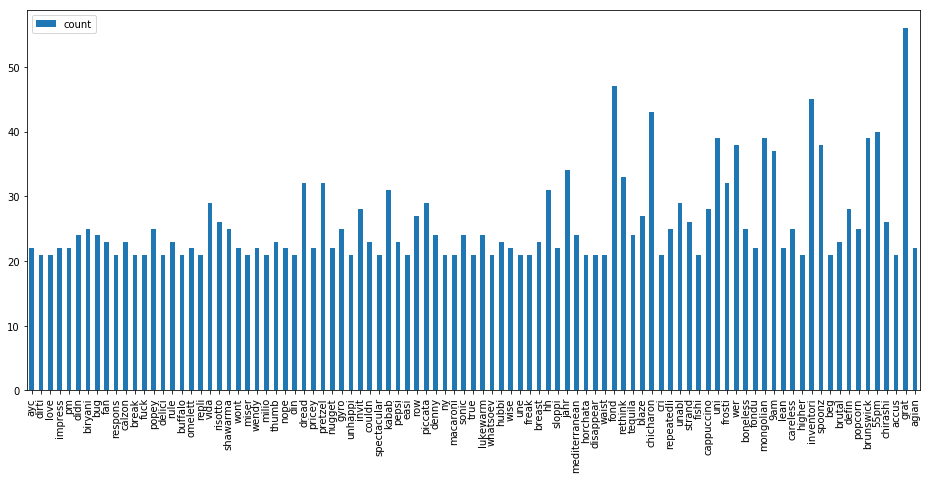

In [253]:
new_df.plot(kind='bar', figsize=(16,7))

In [233]:
df6.groupby("business_id").count()

,user_name,user_id,friends,business_name,state,city,address,categories,bus_star,text,review_star
business_id,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,45,45,45,45,45,45,45,45,45,45,45
-49WY_TEa9ZEcRk_GnuLog,4,4,4,4,4,4,4,4,4,4,4
-7bRnaHp7OHz8KW-THqP4w,7,7,7,7,7,7,7,7,7,7,7
-HLGtKB3XtyawZAuvNoQjQ,3,3,3,3,3,3,3,3,3,3,3
-K3kqmykKlhlB4arCsLHOw,31,31,31,31,31,31,31,31,31,31,31
-R_dMb9Z1eBv_FlYZrrKbw,2,2,2,2,2,2,2,2,2,2,2
-VAsjhmAbKF3Pb_-8rh3xg,4,4,4,4,4,4,4,4,4,4,4
-YSCL35R3g6qqvHordSxVw,1,1,1,1,1,1,1,1,1,1,1
-Yq3_hzWqsPR3s8SLyQ2fQ,1,1,1,1,1,1,1,1,1,1,1
